In [1]:
import osmnx as ox
from geopy.distance import geodesic
import geopy
import pyproj
import math
from uuid import uuid4

In [556]:
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import random
%matplotlib inline 

import seaborn as sns
import json
from shapely.geometry import Point, LineString

In [3]:
city = ox.geocode_to_gdf('V. kerület')

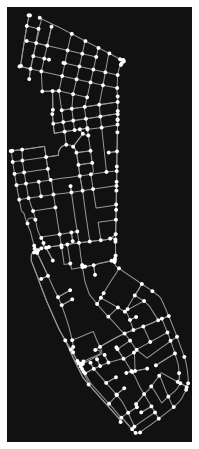

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
G = ox.graph_from_place('V. kerület', network_type='drive')
ox.plot_graph(G)


In [50]:
nodes, streets = ox.graph_to_gdfs(G)
streets[:10]

osmid  oneway  \
u        v          key                                                       
26732173 84708496   0                                      23681399    True   
         171507014  0    [24005922, 24042923, 646403348, 371909283]    True   
26733991 84700676   0                         [17275204, 217483071]   False   
         260238323  0                        [553123799, 127553887]   False   
         1433298790 0                                     262231175   False   
49405178 1382906629 0                                      16608102    True   
         49405188   0                        [325386555, 553110630]    True   
49405188 84708751   0                                      56066922    True   
         49405195   0                        [125067714, 553110629]    True   
49405195 260097053  0                        [553113144, 553113143]    True   

                                                              name  \
u        v          key                                              
26732173 84708496   0                             Arany János utca   
         171507014  0    [Széchenyi István tér, Széchenyi rakpart]   
26733991 84700676   0                           József Attila utca   
         260238323  0                         Bajcsy-Zsilinszky út   
         1433298790 0                         Bajcsy-Zsilinszky út   
49405178 1382906629 0                         Széchenyi István tér   
         49405188   0                         Széchenyi István tér   
49405188 84708751   0                         Széchenyi István tér   
         49405195   0                         Széchenyi István tér   
49405195 260097053  0                         Széchenyi István tér   

                               highway   length lanes maxspeed  \
u        v          key                                          
26732173 84708496   0      residential   66.330   NaN      NaN   
         171507014  0      residential  180.779     1       50   
26733991 84700676   0         tertiary   50.159     5       50   
         260238323  0        secondary  101.313     7       50   
         1433298790 0        secondary   38.110     7       50   
49405178 1382906629 0    tertiary_link   21.508     1      NaN   
         49405188   0         tertiary   60.882     2       50   
49405188 84708751   0         tertiary   34.897     1       50   
         49405195   0    tertiary_link   44.421     1       50   
49405195 260097053  0         tertiary   38.662     3       50   

                                                                  geometry  \
u        v          key                                                      
26732173 84708496   0    LINESTRING (19.04581 47.50169, 19.04668 47.50179)   
         171507014  0    LINESTRING (19.04581 47.50169, 19.04601 47.501...   
26733991 84700676   0    LINESTRING (19.05484 47.49951, 19.05459 47.499...   
         260238323  0    LINESTRING (19.05484 47.49951, 19.05485 47.499...   
         1433298790 0    LINESTRING (19.05484 47.49951, 19.05484 47.499...   
49405178 1382906629 0    LINESTRING (19.04721 47.49878, 19.04725 47.49859)   
         49405188   0    LINESTRING (19.04721 47.49878, 19.04736 47.498...   
49405188 84708751   0    LINESTRING (19.04787 47.49861, 19.04833 47.49865)   
         49405195   0    LINESTRING (19.04787 47.49861, 19.04801 47.498...   
49405195 260097053  0    LINESTRING (19.04809 47.49895, 19.04801 47.499...   

                        access tunnel bridge  
u        v          key                       
26732173 84708496   0      NaN    NaN    NaN  
         171507014  0      NaN    NaN    NaN  
26733991 84700676   0      NaN    NaN    NaN  
         260238323  0      NaN    NaN    NaN  
         1433298790 0      NaN    NaN    NaN  
49405178 1382906629 0      NaN    NaN    NaN  
         49405188   0      NaN    NaN    NaN  
49405188 84708751   0      NaN    NaN    NaN  
         49405195   0      NaN    NaN    NaN  
49405195 260097053  0    

In [7]:
geodesic = pyproj.Geod(ellps='WGS84')

In [439]:
car_length = 8
distance_between_lanes = 4
distance_to_parking_spots = 4
length = streets.iloc[1].length
# oneway = streets.iloc[1].oneway
oneway = False
number_of_spots = length / car_length

lat, lon = streets.iloc[1].geometry.coords.xy

parking_spots_left = []
parking_spots_right = []
segments_centers = []

forward_segments = []
backward_segments = []
        
for index, (current_lat, current_lon) in enumerate(zip(lat, lon)):
    if index < len(lat)-1:
        next_lat, next_lon = lat[index+1], lon[index+1]
        fwd_azimuth,back_azimuth,distance = geodesic.inv(current_lon,current_lat,next_lon,next_lat)
        number_of_cars = max(math.floor(distance/car_length), 1)
    
        r = geodesic.inv_intermediate(current_lon,current_lat,next_lon,next_lat, number_of_cars)
        center_points = list(zip(r.lats, r.lons, [str(uuid4())] * len(r.lats)))
        
        if oneway:
            for (center_lat, center_lon, segment_id) in center_points:
                forward_segments.append((center_lat, center_lon, segment_id))
                parking_spot_left = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth + 135,npts=1,del_s=distance_to_parking_spots )
                parking_spot_right = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth - 45,npts=1,del_s=distance_to_parking_spots)
                parking_spots_left.append((parking_spot_left.lats[0],parking_spot_left.lons[0], segment_id ))
                parking_spots_right.append((parking_spot_right.lats[0],parking_spot_right.lons[0], segment_id))
        else:
            for (center_lat, center_lon, segment_id) in center_points:
                forward_segment_center = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth - 90,npts=1,del_s=distance_between_lanes / 2)
                forward_segment = (forward_segment_center.lats[0],forward_segment_center.lons[0], str(uuid4()))
                forward_segments.append(forward_segment)
                parking_spot_left_center = geodesic.fwd_intermediate(forward_segment[1],forward_segment[0],fwd_azimuth - 45,npts=1,del_s=distance_to_parking_spots)
                parking_spots_left.append((parking_spot_left_center.lats[0],parking_spot_left_center.lons[0], forward_segment[2] ))
                
                backward_segment_center = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth + 90,npts=1,del_s=distance_between_lanes / 2)
                backward_segment = (backward_segment_center.lats[0],backward_segment_center.lons[0], str(uuid4()))
                backward_segments.append(backward_segment)
                parking_spot_right_center = geodesic.fwd_intermediate(backward_segment[1],backward_segment[0],fwd_azimuth + 135,npts=1,del_s=distance_to_parking_spots)
                parking_spots_right.append((parking_spot_right_center.lats[0],parking_spot_right_center.lons[0], backward_segment[2] ))

                
for index, current_item in enumerate(forward_segments):
    #print(index, current_item)
    if index == len(forward_segments)-1:
        segments_centers.append((current_item[0], current_item[1], current_item[2], None))
    else:
        next_item = forward_segments[index+1]
        segments_centers.append((current_item[0], current_item[1], current_item[2], next_item[2]))

        
reversed_backward_segments = list(reversed(backward_segments))
for index, current_item in enumerate(reversed_backward_segments):
    #print(index, current_item)
    if index == len(reversed_backward_segments)-1:
        segments_centers.append((current_item[0], current_item[1], current_item[2], None))
    else:
        next_item = reversed_backward_segments[index+1]
        segments_centers.append((current_item[0], current_item[1], current_item[2], next_item[2]))



In [606]:
car_length = 10
distance_between_lanes = 6
distance_to_parking_spots = 8

def get_segments_and_parking_spots_for_way(way):
    length = way.length
    oneway = way.oneway
    number_of_spots = length / car_length

    lat, lon = way.geometry.coords.xy

    parking_spots_left = []
    parking_spots_right = []
    segments_centers = []

    forward_segments = []
    backward_segments = []
    
    linked_forward_segments = []
    linked_backward_segments = []

    for index, (current_lat, current_lon) in enumerate(zip(lat, lon)):
        last_way_part = index == len(lat) - 1
        
        if index < len(lat)-1:
            next_lat, next_lon = lat[index+1], lon[index+1]
            fwd_azimuth,back_azimuth,distance = geodesic.inv(current_lon,current_lat,next_lon,next_lat)
            number_of_cars = max(math.floor(distance/car_length), 1)

            r = geodesic.inv_intermediate(current_lon,current_lat,next_lon,next_lat, number_of_cars)
            center_points = list(zip(r.lats, r.lons, [f'seg-{str(uuid4())}' for _ in range(len(r.lats))]))

            if oneway:
                for point_index, (center_lat, center_lon, segment_id) in enumerate(center_points):
                    forward_segments.append((center_lat, center_lon, segment_id, False))
                    
                    # we don't allow parking spots at the beginning and end of the road
                    if not (index == 0 and point_index == 0) and not (index == last_way_part and point_index == len(center_points) -1):
                        parking_spot_left = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth + 135,npts=1,del_s=distance_to_parking_spots )
                        parking_spot_right = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth - 45,npts=1,del_s=distance_to_parking_spots)
                        parking_spots_left.append((parking_spot_left.lats[0],parking_spot_left.lons[0], segment_id, False ))
                        parking_spots_right.append((parking_spot_right.lats[0],parking_spot_right.lons[0], segment_id, False))
                        
            else:
                for point_index, (center_lat, center_lon, segment_id) in enumerate(center_points):
                    forward_segment_center = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth - 90,npts=1,del_s=distance_between_lanes / 2)
                    forward_segment = (forward_segment_center.lats[0],forward_segment_center.lons[0],f'seg-{str(uuid4())}', False)
                    forward_segments.append(forward_segment)
                    
                    backward_segment_center = geodesic.fwd_intermediate(center_lon,center_lat,fwd_azimuth + 90,npts=1,del_s=distance_between_lanes / 2)
                    backward_segment = (backward_segment_center.lats[0],backward_segment_center.lons[0], f'seg-{str(uuid4())}', True)
                    backward_segments.append(backward_segment)
                    
                    if not (index == 0 and point_index == 0) and not (index == last_way_part and point_index == len(center_points) -1):
                        parking_spot_left_center = geodesic.fwd_intermediate(forward_segment[1],forward_segment[0],fwd_azimuth - 45,npts=1,del_s=distance_to_parking_spots)
                        parking_spots_left.append((parking_spot_left_center.lats[0],parking_spot_left_center.lons[0], forward_segment[2], False ))

                        parking_spot_right_center = geodesic.fwd_intermediate(backward_segment[1],backward_segment[0],fwd_azimuth + 135,npts=1,del_s=distance_to_parking_spots)
                        parking_spots_right.append((parking_spot_right_center.lats[0],parking_spot_right_center.lons[0], backward_segment[2], True ))

    parking_spots = parking_spots_left + parking_spots_right
    return forward_segments, list(reversed(backward_segments)), parking_spots

In [607]:
all_segments = []
all_parking_spots = []
node_segments = []
indexes_list = []
parking_spots_list = []
parking_spots_index_list = []
all_segments_list = []
    
for index, row in streets.iterrows():
    forward_segments, backward_segments, parking_spots = get_segments_and_parking_spots_for_way(row)
    
    if row['highway'] == 'residential':
        all_parking_spots += parking_spots
    
    all_segments += forward_segments + backward_segments
    
    node_segments.append([[segment[2] for segment in forward_segments]])
    indexes_list.append((index[0], index[1]))

    
    if not row['oneway']:
         indexes_list.append((index[1], index[0]))
         node_segments.append([[segment[2] for segment in backward_segments]])
        
    for spot in parking_spots:
        current = {
            'id': str(uuid4()),
            'lat': spot[0],
            'lon': spot[1],
            'segment_id': spot[2],
            'parking_vehicle': None,
            'reported_empty': False
        }
        
        if spot[3]:
            parking_spots_index_list.append((index[1], index[0]))
            current['route_starting_node'] = index[1]
            current['route_ending_node'] = index[0]
        else:
            current['route_starting_node'] = index[0]
            current['route_ending_node'] = index[1]
            parking_spots_index_list.append((index[0], index[1]))
            
        parking_spots_list.append(current)
        
    for segment in (forward_segments + backward_segments):
        if segment[3]:
            all_segments_list.append({
                'id': segment[2],
                'route_starting_node': index[1],
                'route_ending_node': index[0],
                'lat': segment[0], 'lon': segment[1]
            })
        else:
            all_segments_list.append({
                'id': segment[2],
                'route_starting_node': index[0],
                'route_ending_node': index[1],
                'lat': segment[0], 'lon': segment[1]
            })

index = pd.MultiIndex.from_tuples(indexes_list, names=["from_node", "to_node"])
node_segments_df = pd.DataFrame(node_segments, index=index)

#parking_spots_index =  pd.MultiIndex.from_tuples(parking_spots_index_list, names=["route_starting_node", "route_ending_node"])
parking_spots_df = pd.DataFrame(parking_spots_list).set_index('id', inplace=False)
all_segments_df = pd.DataFrame(all_segments_list).set_index('id', inplace=False)

In [609]:
frontend_folder = '../bosch-traffic-simulation-frontend/src/pages/MapPage/data'
segments_export = [{'lat': segment[0], 'lon': segment[1], 'id': segment[2]} for segment in all_segments]
with open(frontend_folder + '/segments.json', 'w') as f:
    json.dump(segments_export, f)
    
parking_export = [{'lat': spot[0], 'lon': spot[1]} for spot in all_parking_spots]
with open(frontend_folder + '/parking.json', 'w') as f:
    json.dump(parking_export, f)
    
print('Parking: ', len(all_parking_spots))
print('Segments: ', len(all_segments))

Parking:  5842
Segments:  7084


In [733]:
# set origin/destination
orig = (19.04582, 47.50168)
dest = ( 19.052934, 47.510462)

# find nearest nodes
n_orig = ox.distance.nearest_nodes(G, orig[0], orig[1])
n_dest = ox.distance.nearest_nodes(G, dest[0], dest[1])

osmnx_route = nx.shortest_path(G, n_orig, n_dest, 'length')

edge_lengths = ox.utils_graph.get_route_edge_attributes(
    G, osmnx_route, 'length')
route_len_m = sum(edge_lengths)
print(route_len_m)

1458.07


In [734]:
def get_route_from_start_to_end(start_node, end_node):
    return nx.shortest_path(G, start_node, end_node, 'length')

In [735]:
target = osmnx_route[0]
streets = streets.sort_index()
node_segments_df = node_segments_df.sort_index()

def get_all_segments_for_route(osmnx_route): 
    all_segments_in_route = []
    
    for start_node, end_node in zip(osmnx_route, osmnx_route[1:]):
        current_segments = node_segments_df.loc[start_node, end_node].values
        all_segments_in_route += current_segments[0][0]
        
    return all_segments_in_route

<Figure size 640x480 with 0 Axes>

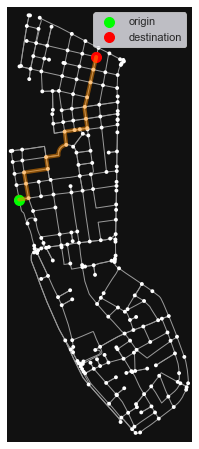

In [742]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
fig, ax = ox.plot_graph_route(
    G, osmnx_route, route_color='darkorange', show=False, close=False, dpi=2000)

ax.scatter(
    G.nodes[n_orig]['x'], G.nodes[n_orig]['y'], 
    c='lime', s=100, label='origin')

ax.scatter(
    G.nodes[n_dest]['x'], G.nodes[n_dest]['y'],
    c='red', s=100, label='destination')


plt.legend()
plt.show()

In [354]:
parking_spots_df = parking_spots_df.sort_index()

# this is not used
def get_empty_spots_for_route(starting_node, ending_node):
    spots = parking_spots_df[(parking_spots_df.route_starting_node == starting_node) & (parking_spots_df.route_ending_node == ending_node) & (parking_spots_df.parking_vehicle == None)]

get_empty_spots_for_route(26732173, 84708496)

In [355]:
def get_empty_spots_from_ways_around_node(node):
    spots = parking_spots_df[((parking_spots_df.route_starting_node == node) | (parking_spots_df.route_ending_node == node)) & (parking_spots_df.parking_vehicle == None)]
    return spots # this is a dataframe

def get_empty_spots_from_ways_around_nodes(nodes):
    spots = parking_spots_df[((parking_spots_df.route_starting_node.isin(nodes)) | (parking_spots_df.route_ending_node.isin(nodes))) & (parking_spots_df.parking_vehicle == None)]
    return spots # this is a dataframe

def get_neighbors_of_node(node):
    neighbors = list(G.neighbors(node))
    return neighbors

def find_empty_spot_recursively(nodes, checked_nodes):
    if len(parking_spots_df[parking_spots_df.parking_vehicle == None].index) == 0:
        return None
    
    spots = get_empty_spots_from_ways_around_nodes(nodes)
    
    if len(spots.index) == 0:
        new_nodes = []
        for node in nodes:
            new_nodes += get_neighbors_of_node(node)
        
        not_checked_new_nodes = [node for node in new_nodes if node not in checked_nodes]
        return find_empty_spot_recursively(not_checked_new_nodes, checked_nodes + not_checked_new_nodes)
            
        
    # TODO now we randomly select a parking spot in a nearby road, could be improved to find by distance
    return spots.sample(n=1).to_dict()
        
    

empty_spots = find_empty_spot_recursively([26732173], [])
# TODO handle if None
empty_spots

In [357]:
# NOT NEEDED
dead_end_street_ending_nodes = list(nodes[nodes['street_count'] == 1].index)
dead_end_streets = []
for ending_node in dead_end_street_ending_nodes:
    starting_nodes = list(G.neighbors(ending_node))
    
    if len(starting_nodes) > 0:
        starting_node = starting_nodes[0]
        dead_end_streets.append((starting_node, ending_node, 0))
        #dead_end_streets.append((ending_node, starting_node, 0))
    
set_valid = set(streets.index).difference(dead_end_streets)


not_dead_end_indexes = [ind for ind in streets.index if ind not in dead_end_streets]
#print(len(dead_end_streets))

streets_without_dead_ends = streets.loc[list(set_valid)]

31
455


In [358]:
random_turns = 3

# the vehicle will do a few randomo turns then navigates back to the destination
def create_nodes_for_random_parking_spot_searching(start_node):
    current_node = start_node
    random_nodes = [start_node]
    
    for turn in range(random_turns):
        neighbors = get_neighbors_of_node(current_node)
        valid_neighbors = [node for node in neighbors if node not in dead_end_street_ending_nodes]
        if current_node in valid_neighbors:
            valid_neighbors.remove(current_node)
        
        selected_node = random.sample(valid_neighbors, 1)[0]
        # TODO: check for empty
        
        random_nodes.append(selected_node)
        current_node = selected_node
    
    
    
    going_back_route = get_route_from_start_to_end(current_node, start_node)
    
    all_nodes = random_nodes + going_back_route
    
    return all_nodes

    
create_nodes_for_random_parking_spot_searching(26732173)

[26732173,
 84708496,
 256427099,
 84708497,
 84708497,
 244940460,
 256427111,
 256427112,
 256427113,
 26732173]

In [359]:
def get_random_destination_node():
    return nodes[~nodes.index.isin(dead_end_street_ending_nodes)].sample(n=1).index.astype(int)


In [610]:
parking_spots_df.to_pickle('./parking_spots.pkl')
node_segments_df.to_pickle('./node_segments.pkl')
all_segments_df.to_pickle('./segments.pkl')

In [393]:
 
def get_route_to_parking_spot(current_segment, parking_spot):
    print(current_segment.name,parking_spot )
    
    start_node = current_segment['route_starting_node']
    current_end_node = current_segment['route_ending_node']
    end_node = parking_spot['route_starting_node']
    
    route = get_route_from_start_to_end(current_end_node, end_node)
    
    segments = get_all_segments_for_route(route)
    
    
    print(start_node,current_end_node)
    segments_in_current_road = node_segments_df.loc[start_node, current_end_node].values[0][0]
    segments_to_start_node = segments_in_current_road[segments_in_current_road.index(current_segment.name):]
    
    segments_in_end_node = node_segments_df.loc[parking_spot['route_starting_node'], parking_spot['route_ending_node']].values[0][0]
    segments_to_end_node = segments_in_end_node[:segments_in_end_node.index(parking_spot['segment_id']) + 1]
    
    print(segments_to_start_node, segments_to_end_node)
    #ending_index = segments.index(parking_spot['segment_id'])
    
    
    #ending_index = segments.index(parking_spot['segment_id'])
    #print(ending_index)
    
    #return segments[starting_index:ending_index]
    
    return segments_to_start_node + segments + segments_to_end_node
    

current_segment = all_segments_df.iloc[100]
print(current_segment)
get_route_to_parking_spot(current_segment, parking_spots_df.iloc[10])


route_starting_node    7.808808e+07
route_ending_node      2.606584e+08
lat                    1.905485e+01
lon                    4.749824e+01
Name: b3598fe5-abbc-4ab0-81d1-af98207790e8, dtype: float64
b3598fe5-abbc-4ab0-81d1-af98207790e8 lat                                               19.046276
lon                                               47.501717
segment_id             53b47665-7516-4bcf-ac67-1a288e75b9e6
parking_vehicle                                        None
route_starting_node                                26732173
route_ending_node                                  84708496
Name: 941c821b-9a09-410e-81c5-48d8a63c0491, dtype: object
78088084.0 260658386.0
['b3598fe5-abbc-4ab0-81d1-af98207790e8', '1597a381-5fe3-4288-95c2-38a3aac4fb8f', 'aad2836e-bc84-47cf-9b27-718d223c0be5', '1ccb4940-5588-4cd2-b184-9375dcbddd50', '7d54fa0f-f067-41c8-ba58-40180115c1e5', '74610f96-7eb8-4f6d-878e-2eb936ab74a7', 'b471d2a7-b415-4b3f-af0b-2d0f2bd09b34', '0a708a0e-0012-4078-86a3-5eed2f5f26ef'

/var/folders/_m/n8cxzl4539d7118fz82k64m80000gn/T/ipykernel_32596/1471647548.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  current_segments = node_segments_df.loc[start_node, end_node].values
/var/folders/_m/n8cxzl4539d7118fz82k64m80000gn/T/ipykernel_32596/2407818336.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  segments_in_current_road = node_segments_df.loc[start_node, current_end_node].values[0][0]
/var/folders/_m/n8cxzl4539d7118fz82k64m80000gn/T/ipykernel_32596/2407818336.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  segments_in_end_node = node_segments_df.loc[parking_spot['route_starting_node'], parking_spot['route_ending_node']].values[0][0]


['b3598fe5-abbc-4ab0-81d1-af98207790e8',
 '1597a381-5fe3-4288-95c2-38a3aac4fb8f',
 'aad2836e-bc84-47cf-9b27-718d223c0be5',
 '1ccb4940-5588-4cd2-b184-9375dcbddd50',
 '7d54fa0f-f067-41c8-ba58-40180115c1e5',
 '74610f96-7eb8-4f6d-878e-2eb936ab74a7',
 'b471d2a7-b415-4b3f-af0b-2d0f2bd09b34',
 '0a708a0e-0012-4078-86a3-5eed2f5f26ef',
 '1919e5a6-efdf-4dc1-b3a9-75ca3fb3e1b7',
 'ce39ab1f-12bb-445e-8668-06a5879a9d57',
 'fabd8970-2226-4bd5-b307-34f9cadb0e0a',
 'e3b617e0-4fae-46ad-ac1c-91e6495c4b56',
 'a79ec65c-becd-4cc8-8489-48b2facf1627',
 '3537c0b6-c915-4279-95f9-2199605f54ae',
 '4a215661-dc50-4600-9326-6a58d05085f5',
 '686033eb-76d9-4f57-a06f-cef10c825e51',
 '964ffdfa-2b39-4eeb-9cc1-9bb16295f71e',
 '38a6809e-3fb7-40f3-9cbe-7574ce6f07a1',
 'e616086c-cb37-4e4c-b335-8272a4668a24',
 'ee47a119-cbde-443c-8425-e404481aa656',
 '1c57c30b-85da-4a9e-bedd-bdf922216317',
 '77b9625b-16ab-4b68-9312-b26c68ecc344',
 '6ba43300-74f9-4dd0-844f-57b98fe885cf',
 '53db3738-5415-47cb-8c29-238971bc2159',
 '673e85c9-7fcf-

In [633]:
sns.set_theme(style="darkgrid")

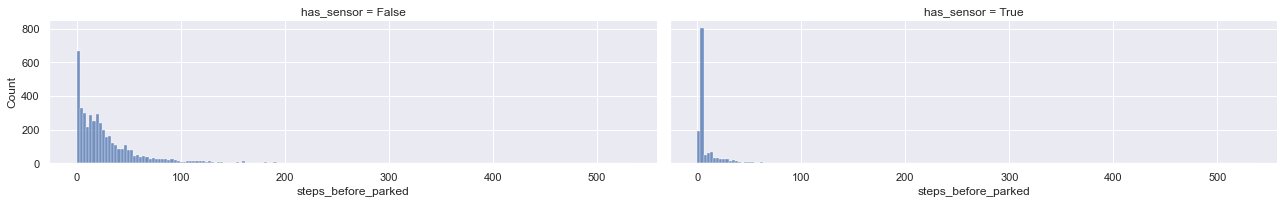

In [634]:
sns.displot(
    analytics_df, x="steps_before_parked", col="has_sensor",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
    aspect=30/10
)

In [688]:
real_nodes = [parking_spots_df.loc[row['parking_segment']]['route_starting_node'] for index, row in analytics_df.iterrows()]

In [690]:
analytics_df['real_end_nodes'] = real_nodes

In [695]:
distances = []

for index, row in analytics_df.iterrows():
    try:
        route = get_route_from_start_to_end(row['real_end_nodes'], row['destination_node'])
        segments = get_all_segments_for_route(route)
        distances.append(len(segments))

    except Exception:
        distances.append(None)

analytics_df['distances'] = distances

/var/folders/_m/n8cxzl4539d7118fz82k64m80000gn/T/ipykernel_32596/1471647548.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  current_segments = node_segments_df.loc[start_node, end_node].values


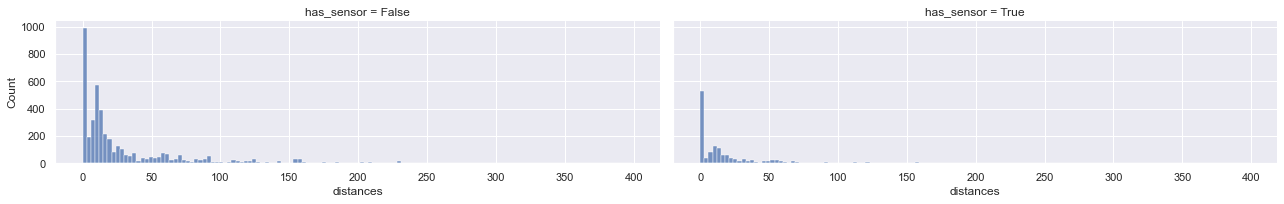

In [731]:
sns.displot(
    analytics_df, x="distances", col="has_sensor",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
    aspect=30/10
)

In [705]:
analytics_df.groupby(['has_sensor']).agg({'steps_before_parked': ['mean', 'std'], 'distances':  ['mean', 'std']})
                                          
                                          

steps_before_parked             distances           
                          mean        std       mean        std
has_sensor                                                     
False                31.966592  43.081730  32.330095  50.401432
True                  9.917713  15.466198  23.053408  40.683004

In [732]:
counts = analytics_df[analytics_df['has_sensor'] == False]['steps_before_parked'].value_counts().to_dict()

for has_sensor in [True, False]:
    for value in ['steps_before_parked', 'distances']:
        counts = analytics_df[analytics_df['has_sensor'] == has_sensor][value].value_counts().to_dict()
        result = [{'x':k, 'y': v, 'name': "With sensor" if has_sensor else "Without sensor"} for k,v in counts.items()]
        with open(frontend_folder + f'/{value}-{"has_sensor" if has_sensor else "no_sensor"}.json', 'w') as f:
            json.dump(result, f)